In [1]:
from pyquil.quil import Program
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()
from pyquil.api import get_qc

In [2]:
import openfermionpyscf as ofpyscf
import openfermion as of
from openfermion.transforms import *
from openfermion.utils import *
from openfermion.hamiltonians import MolecularData
from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
import numpy as np
import pyscf

In [3]:
def h2_bk(x):
    #1
    prog=Program()
    prog+=X(0)
    prog+=H(0)
    prog+=RX(1.57,2)
    prog+=CNOT(0,1)
    prog+=CNOT(1,2)
    prog+=RZ(x[0],2)
    prog+=CNOT(1,2)
    prog+=CNOT(0,1)
    prog+=H(0)
    prog+=RX(-1.57,2)
    
    #2
    prog+=H(0)
    prog+=RX(1.57,2)
    prog+=CNOT(0,1)
    prog+=CNOT(1,2)
    prog+=CNOT(2,3)
    prog+=RZ(x[0],2)
    prog+=CNOT(2,3)
    prog+=CNOT(1,2)
    prog+=CNOT(0,1)
    prog+=H(0)
    prog+=RX(-1.57,2)
    
    #3
    prog+=H(0)
    prog+=RX(1.57,2)
    prog+=CNOT(0,2)
    prog+=RZ(x[0],2)
    prog+=CNOT(0,2)
    prog+=H(0)
    prog+=RX(-1.57,2)
    
    #4
    prog+=H(0)
    prog+=RX(1.57,2)
    prog+=CNOT(0,2)
    prog+=CNOT(2,3)
    prog+=RZ(x[0],3)
    prog+=CNOT(2,3)
    prog+=CNOT(0,2)
    prog+=H(0)
    prog+=RX(-1.57,2)
    
    #5
    prog+=RX(1.57,0)
    prog+=H(2)
    prog+=CNOT(0,1)
    prog+=CNOT(1,2)
    prog+=RZ(x[1],2)
    prog+=CNOT(1,2)
    prog+=CNOT(0,1)
    prog+=RX(-1.57,0)
    prog+=H(2)
    
    #6
    prog+=RX(1.57,0)
    prog+=H(2)
    prog+=CNOT(0,1)
    prog+=CNOT(1,2)
    prog+=CNOT(2,3)
    prog+=RZ(x[1],3)
    prog+=CNOT(2,3)
    prog+=CNOT(1,2)
    prog+=CNOT(0,1)
    prog+=RX(-1.57,0)
    prog+=H(2)
    
    
    #7
    prog+=RX(1.57,0)
    prog+=H(2)
    prog+=CNOT(0,2)
    prog+=RZ(x[1],2)
    prog+=CNOT(0,2)
    prog+=RX(-1.57,0)
    prog+=H(2)
    
    #8
    prog+=RX(1.57,0)
    prog+=H(2)
    prog+=CNOT(0,2)
    prog+=CNOT(2,3)
    prog+=RZ(x[1],3)
    prog+=CNOT(2,3)
    prog+=CNOT(0,2)
    prog+=RX(-1.57,0)
    prog+=H(2)
    
    return prog

In [4]:
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

In [5]:
from grove.pyvqe.vqe import VQE
from scipy.optimize import minimize
import numpy as np

vqe_inst = VQE(minimizer=minimize,minimizer_kwargs={'method': 'nelder-mead'})

In [6]:
bond_length_interval = 0.1
n_points = 25

                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be ineffective
                     models will be inef

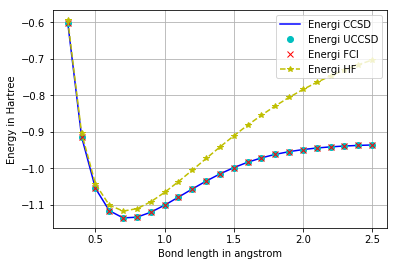

In [12]:
ccsd_energies = []
fci_energies=[]
vqe_uccsd_energies = []
bond_lengths = []
hf_energies=[]
E=[]
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
    #print("Jarak Antar Atom=",description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule1 = MolecularData(
        geometry, basis, multiplicity, description=description)
    molecule1.load()
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
    hamiltonian_bk=bravyi_kitaev(get_fermion_operator(hamiltonian))
    hamiltonian_bk_pauli=qubitop_to_pyquilpauli(hamiltonian_bk)
    
    x= vqe_inst.vqe_run(h2_bk, hamiltonian_bk_pauli, [0.0,0.0], None, qvm=qvm)
    E.append(x.fun)
    ccsd_energies += [molecule1.ccsd_energy]
    fci_energies += [molecule1.fci_energy]
    hf_energies += [molecule1.hf_energy]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(0)
plt.plot(bond_lengths, ccsd_energies, 'b-',label='Energi CCSD')
plt.plot(bond_lengths, E, 'co',label='Energi UCCSD')
plt.plot(bond_lengths, fci_energies,'rx',label='Energi FCI')
plt.plot(bond_lengths, hf_energies,'y--*',label='Energi HF')
plt.grid()
plt.legend(loc=1)
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

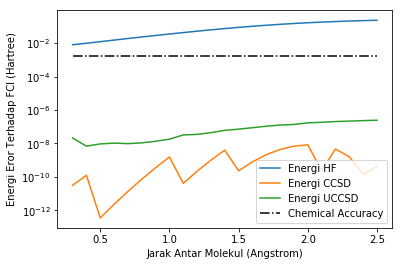

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,hf_energies)),label='Energi HF')
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,ccsd_energies)),label='Energi CCSD')
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,E)),label='Energi UCCSD')
plt.semilogy(bond_lengths,0.0016*np.ones([len(bond_lengths),1]),label='Chemical Accuracy',linestyle='-.',color='black')
plt.xlabel('Jarak Antar Molekul (Angstrom)')
plt.ylabel('Energi Eror Terhadap FCI (Hartree)')
#plt.title('Error Terhadap FCI - Disassociation curve hydrogen molecule')
plt.legend()